## Loading our CTR data for A/B Test

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import norm

In [3]:
df_ab_test = pd.read_csv('ab_test_data.csv')

#print(df_ab_test.head(), "\n")
print(df_ab_test.describe(), "\n")
print(df_ab_test.groupby("group").sum("click"))

            user_id         click
count  20000.000000  20000.000000
mean   10000.500000      0.401150
std     5773.647028      0.490144
min        1.000000      0.000000
25%     5000.750000      0.000000
50%    10000.500000      0.000000
75%    15000.250000      1.000000
max    20000.000000      1.000000 

         user_id  click
group                  
con    150005000   2016
exp     50005000   6007


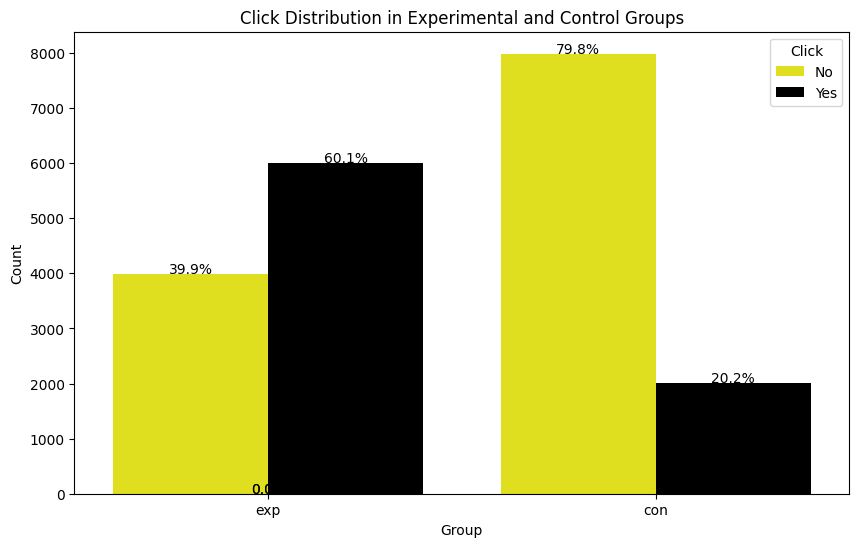

In [4]:
# Custom palette for yellow and black
palette = {0: 'yellow', 1: 'black'} # Assuming 0 is for no-click, 1 for click

# Plotting the click distribution for each group with the custom colors
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='group', hue='click', data=df_ab_test, palette=palette)
plt.title( 'Click Distribution in Experimental and Control Groups')
plt.xlabel( 'Group')
plt.ylabel( 'Count')
plt.legend(title='Click', labels=['No', 'Yes'])

# Calculate the percentages and annotate the bars
group_counts = df_ab_test.groupby(['group']).size()
group_click_counts = df_ab_test.groupby(['group', 'click']).size().reset_index(name='count')

for p in ax.patches:
    height = p.get_height()
    
    # Find the group and click type for the current bar
    group = 'exp' if p.get_x() < 0.5 else 'con'
    click = 1 if p.get_x() % 1 > 0.5 else 0
    total = group_counts.loc[group]
    percentage = 100 * height/total
    ax.text(p.get_x() + p.get_width() / 2., height+5, f'{percentage:.1f}%', ha = "center", color = 'black', fontsize = 10 )


## Parameters of the model from Power Analysis


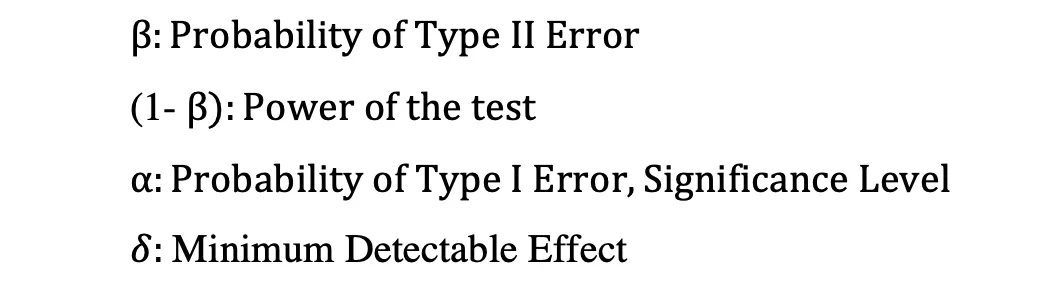

In [5]:
alpha = 0.05 # 5%
print ("Alpha: Significance level is: ", alpha)

delta = 0.1 # 10%
print ("Delta: Minimum detectable effect is: ", delta)

Alpha: Significance level is:  0.05
Delta: Minimum detectable effect is:  0.1


In [6]:
n_con = df_ab_test[df_ab_test["group"] == "con"].count().loc["group"] # Can also use df_ab_test[df_ab_test["group"] == "con"].shape[0]
n_exp = df_ab_test[df_ab_test["group"] == "exp"].count().loc["group"] # Can also use df_ab_test[df_ab_test["group"] == "exp"].shape[0]

x_con = df_ab_test.groupby("group")["click"].sum().loc["con"]
x_exp = df_ab_test.groupby("group")["click"].sum().loc["exp"]

print(df_ab_test.groupby("group")["click"].sum())
print("Number of users in Control: ", n_con)
print("Number of users in Experimental: ", n_exp)
print("Number of clicks in Control: ", x_con)
print("Number of clicks in Experimental: ", x_exp)

group
con    2016
exp    6007
Name: click, dtype: int64
Number of users in Control:  10000
Number of users in Experimental:  10000
Number of clicks in Control:  2016
Number of clicks in Experimental:  6007


## Calculating Pooled Estimates for Clicks Per Group

In [7]:
# Computing estimate of click probability per group
p_con_hat = x_con/n_con
p_exp_hat = x_exp/n_exp

print("Click probability in control group: ", p_con_hat)
print("Click probability in experimental group: ", p_exp_hat)


# Computing the estimate of pooled clicked probability
p_pooled_hat = (x_con + x_exp) / (n_con + n_exp) 
print("Pooled click probability: ", p_pooled_hat)

Click probability in control group:  0.2016
Click probability in experimental group:  0.6007
Pooled click probability:  0.40115


## Calculating Pooled Variance

In [8]:
pooled_variance = p_pooled_hat * (1-p_pooled_hat) * (1/n_con + 1/n_exp)
print("Pooled variance is: ", pooled_variance)

Pooled variance is:  4.80457355e-05


## Calculating Standard Error and Test Statistics

In [9]:
se = np.sqrt(pooled_variance)
print("Standard error is: ", se)

test_stat = (p_con_hat - p_exp_hat) / se
print("Test statistics for 2-sample Z-test is: ", test_stat) # At 1:55 she talks of why she chose 2-sample Z-test. Smth to do with central limit theorem as well.

z_crit = norm.ppf(1-alpha/2)
print ("Z-critical value from standard normal distribution: ", z_crit)

Standard error is:  0.006931503119814633
Test statistics for 2-sample Z-test is:  -57.57769896389703
Z-critical value from standard normal distribution:  1.959963984540054


## Calculating p_values of the Z-test  
A low p-value (p < 0.05 at 5% significance level) indicates strong evidence against the null hypothesis, so we reject the null hypothesis.  
A high p-value (p > 0.05) indicates weak evidence against the null hypothesis, so we fail to reject the null hypothesis.


In [10]:
# Calulating p value
p_value = 2 * norm.sf(abs(test_stat))
#print(p_value)

# function checking the statistical significance
def is_statistical_significance(p_value, alpha):
    """
    We assess whether there is statistical significance based on the p-value and alpha.
    
    Arguments:
    - p_value (float): The p-value resulting from a statistical test.
    - alpha (float, optional): The significance level threshold used to determine statistical significance. Defaults to 0.05.
    
    Returns:
    - Prints the assessment of statistical significance.
    """
    # Print the rounded p-value to 3 decimal places
    print(f"p-value of the 2-sample Z-test: {round(float(p_value), 3)}")
    
    # Determing statistical significance
    if p_value <= alpha:
        print ("There is statistical significance, indicating that that observed differences between the group are unlikely to have occured by chance. This suggests that the change is working.")
    else:
        print ("There is NO statistical significance, suggesting that that observed differences between the group could have occured by chance. This suggests that the change is NOT working.")


is_statistical_significance(p_value, alpha)

p-value of the 2-sample Z-test: 0.0
There is statistical significance, indicating that that observed differences between the group are unlikely to have occured by chance. This suggests that the change is working.


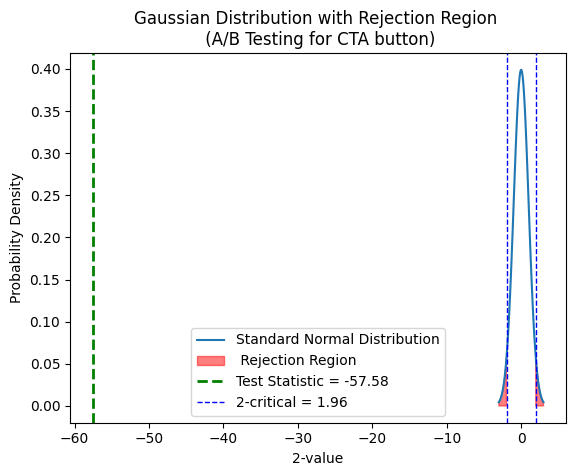

In [11]:
# Parameters for the standard normal distribution
mu = 0 # Mean
sigma = 1 # Standard deviation
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = norm.pdf(x, mu, sigma)

# Test statistics and critical value from previous calculation
#test_stat = -42.71219397822086 # This value is from your A/B test results
#z_crit = 1.959963984540054 # Z-critical value for a 5% significance level in a two-tailed test

# Plotting the standard normal distribution
plt.plot(x, y, label='Standard Normal Distribution')
# Shade the rejection region for a two-tailed test
plt.fill_between(x, y, where=(x > z_crit) | (x <-z_crit), color='red', alpha=0.5, label=' Rejection Region')

# Adding Test Statistic
plt.axvline(test_stat, color='green', linestyle='dashed', linewidth=2, label=f'Test Statistic = {test_stat:.2f}')
# Adding Z-critical values
plt.axvline(z_crit, color='blue', linestyle='dashed', linewidth=1, label=f'2-critical = {z_crit:.2f}')
plt.axvline(-z_crit, color='blue', linestyle= 'dashed', linewidth=1)

# Adding labels and title
plt.xlabel('2-value')
plt.ylabel( 'Probability Density')
plt. title( 'Gaussian Distribution with Rejection Region \n (A/B Testing for CTA button)')
plt. legend()
# Show plot
plt.show()


## Calculating Confidence Interval of Test

In [12]:
# Calculate the Confidence Interval (CI) for a 2-sample Z-test
## Calculate the lower and upper bounds of the confidence interval
ci = [
     round((p_exp_hat - p_con_hat) - se * z_crit, 3), # Lower bound of the CI, rounded to 3 decimal places
     round((p_exp_hat - p_con_hat) + se * z_crit, 3) # Upper bound of the CI, rounded to 3 decimal places
]

# Print the calculated confidence interval
print("Confidence Interval of the 2 sample Z-test is: ", ci)


Confidence Interval of the 2 sample Z-test is:  [0.386, 0.413]


## Testing for Practical Significance

In [13]:
def is_Practically_significant (delta, ci_95):
    
    """We assess here if the difference between Control and Experimental group is practically significant using the Minimum Detectable Effect (MDE)
    
    Arguments:
    - delta (float): The Minimum Detectable Effect (MDE) considered for practical significance.
    - CI_95 (tuple): A tuple representing the lower and upper bounds of the 95% Confidence Interval.
    
    Returns:
    Prints whether the experiment has practical significance based on the MDE and CI.
    """
    # Extract lower bound of 95% Confidence Interval
    lower_bound_CI = ci_95[0]
    
    # Check if the lower bound of the CI is greater than or equal to delta
    if lower_bound_CI <= delta:
        print(f"We have practical significance! \nWith MDE of {delta}, the difference between Control and Experimental groups is practically significant")
        return True
    else:
        print(f"We don't have practical significance! \nThe difference between Control and Experimental groups is not practically significant")
        
# Example pf using this func
ci_95 = (0.04, 0.06)

# Call the function
significance = is_Practically_significant(delta, ci_95)
print("Lower bound of 95% confidence interval is: ", ci_95[0])

We have practical significance! 
With MDE of 0.1, the difference between Control and Experimental groups is practically significant
Lower bound of 95% confidence interval is:  0.04
